# 1. Experiment 2: 
"find parameters for synthetic observation(s) reserved from the process-based model upon which the surrogate model was trained"
1. Build Surrogate of ParFlow streamflow, `lstm_A`
2. Construct amortized (full) P(`theta | q_surr_all`) via a Neural Density Estimator, or `NDE`
3. Sample posterior, P(`theta | q_surr_all = q_PF_obs`)
4. Interpretive Plots

##### --------
* Steps 1, 2 and embedded in the `lstm_sbi.py` 'run' script
* steps 3, 4 are shown below. 
* See `/home/qh8373/SBI_TAYLOR/sbi_taylor/psuedocode-sbi-experiments.md` for full details about the experiment

* NOTES:
    * Many Workflows tested and lent from:
        * `AGU_Synthesis.ipynb`
        * `SBI_Interp_Agg.ipynb`
        * `test_lstm_sbi.ipynb`

In [1]:
import os
import os.path
import sys
import shutil
from pprint import pprint
from datetime import datetime
from copy import copy
from copy import deepcopy
import pickle

from parflowio.pyParflowio import PFData

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import seaborn as sns
from seaborn import pairplot
from seaborn import jointplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import glob


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import spotpy
import spotpy.objectivefunctions as obj_mets


# -- Libararies  
import os
import sys
import pickle
import torch
from random import *

# for SBI
from sbi import utils as utils
from sbi import analysis as analysis
from sbi import inference
from sbi.inference.base import infer
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.types import Array, OneOrMore, ScalarFloat

from matplotlib import pyplot as plt

import numpy as np
from numpy import cov
from numpy.linalg import det, norm # determinant, norm (used to calculate 'euclidean' distance)

import random
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from seaborn import pairplot
from seaborn import jointplot
import pandas as pd
from parflowio.pyParflowio import PFData
# import pygmmis <- This was the default but it doesn't work very well
from sklearn.mixture import GaussianMixture as GMM
import sys
import os
from datetime import datetime

# for machine learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset # for refactoring x and y
from torch.utils.data import DataLoader # for batch submission
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Independent, Uniform
from torch.distributions.log_normal import LogNormal

# for scaling
from sklearn.preprocessing import MinMaxScaler

# for stats
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from assessutils import compute_stats
import re
from scipy.stats import mode

# helpers
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/03_sbi_lstm/')
from sbi_build import simulate

# Path to the SandTank Repo
dev_path = '/home/SHARED/ML_TV/HydroGEN/modules/'
#Add Sand Tank path to the sys path
sys.path.append(dev_path)
from transform import float32_clamp_scaling

# user defined functions
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from genutils import PFread, plot_stuff, convertNumpy
from ensembleutils import assembleYears, assembleAllForcings, parseAllMetadata, returnDF_ens, returnAOC_ens, _ret_MinMax, _ret_AOCMinMax
from assessutils import compute_stats
from scalerutils import scaled_ens_Values, scaledForcingData, scaledAOCData
from posteriorsamputils import statTheta, genProbThetas, gen_Fit_Series_Wrapper
from summaryutils import summary, setStatSim
from sbiutils import retStatTyp, parseListDf, parseUniqueParams
from sbiutils import reshape_y, createYHatList, createYHat
from interputils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.tri as tri
import pickle
import sys
import torch

import scipy
from scipy.spatial import distance

/home/SHARED/software/anaconda3/2020.07e/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## 3. Sample posterior, P(`theta | q_surr_all = q_PF_obs`)
* Default routine samples each posterior just once

## 4. Interpretive Plots


# -------------------------------------

### *Dimension 1* - Using the single surrogate model from `lstm_A`
### Loading SBI Posteriors

In [2]:
# Directories
sbi_run  = '0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate'
print(sbi_run)
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/{sbi_run}/'

try:
    os.mkdir(f'{save_dir}')
except:
    print('warning: file exists')
    pass

print(save_dir)

lstm_name = '02_05_lstm_A'
lstm_path = f'/home/qh8373/SBI_TAYLOR/data/04_lstm_out/{lstm_name}/'

# load lstm info
with open(lstm_path+'list_df_cond.pkl', 'rb') as fp:
    list_df_cond = pickle.load(fp)

0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate
/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate/


### a. Interpretive plots for each synthetic observations, parameters only

#### Selection Criteria and Load Posterior

In [33]:
# Selection Criteria
sub = 0 # Posterior Sub (Lsim=0 to 10)
idx = 4 #PF:LSTM, 0=82, 1=83, .... #Observation
lstm_idx = 0 #LSTM number in ensemble, nb: should be the same idx as that used in inference = 0
n_samples = 5000 
sbi_dir_sub = f'{sbi_dir}{sub}/'

add_noise=True
f_noise=1e-2

# load posterior
with open(sbi_dir_sub+'posterior.pkl', 'rb') as fp:
    posterior = pickle.load(fp)

#### General loading for posterior sampling

In [34]:
'''
ParFlow truth loads
lstm_df_cond should be loaded
to test ParFlow truths on models trained with LSTMs and previous tested with LSTM synthetic truths
'''
DataX_test, DataY_test, series_len, lstm_out_list = parseListDf(list_df_cond)
test_params, num_params, num_unique, DataX_test = parseUniqueParams(DataX_test, series_len)


'''
sample observation (y_hat) and 'correct' parameter (true_theta)
    y_hat_full is the full timeseries (important for embed and summary stat method)
'''
true_theta = test_params[idx]

#### Sample Posterior (Emulated)

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


<ipython-input-35-d7bf42b045e2>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),



the theta value is tensor([0.7188, 0.2500]) 

Emulated


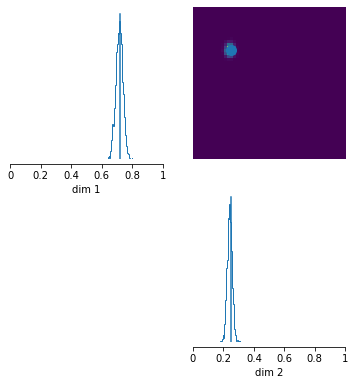

In [35]:
# emulated streamflow
y_hat_full = reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx]))
y_hat = createYHat(y_hat_full, stat_method='full', stat_typ=None, embed_type=None)

'''
sample posterior and create log probability
'''
# emulated
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples = posterior.sample((n_samples,), x=y_hat) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability = posterior.log_prob(posterior_samples, x=y_hat).unsqueeze(1) # type - tensor object

'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('Emulated')
fig, ax = analysis.pairplot(posterior_samples, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated.eps', format='eps')

plt.show()

#### Sample Posterior (ParFlow)
* nb: to check for bias

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


<ipython-input-36-f65cfd99aa59>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),



the theta value is tensor([0.7188, 0.2500]) 

PARFLOW


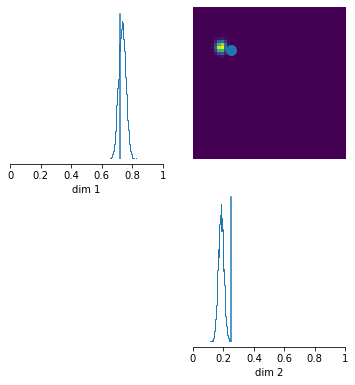

In [36]:
# PF
unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method='full', stat_typ=None, embed_type=None)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)
y_hat_PF = unique_series_PF[idx]
y_hat_full_PF = unique_series_full_PF[idx]

'''
sample posterior and create log probability
'''
# PF
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples_PF = posterior.sample((n_samples,), x=y_hat_PF) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability_PF = posterior.log_prob(posterior_samples_PF, x=y_hat_PF).unsqueeze(1) # type - tensor object


'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('PARFLOW')
fig, ax = analysis.pairplot(posterior_samples_PF, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.eps', format='eps')

plt.show()



In [15]:
posterior_samples_PF.quantile(q=0.5, dim=0,keepdim=True) -  true_theta
# help(posterior_samples_PF.quantile)

tensor([[-0.0889, -0.0324]])

In [16]:
print(log_probability.min())
print(log_probability.max())
print(log_probability.mean(), '\n')

print(log_probability_PF.min())
print(log_probability_PF.max())
print(log_probability_PF.mean(), '\n')

tensor(-1.7786)
tensor(6.3022)
tensor(5.3036) 

tensor(-3.1285)
tensor(6.5124)
tensor(5.5377) 



In [17]:
# emulated
# to run forward in ParFlow (maybe)
out_params_1, out_logprob_1, out_idxs_1 = randBootstrap(posterior_samples, log_probability, n=10)


print(out_params_1)

tensor([[0.5781, 0.8681],
        [0.6094, 0.8759],
        [0.6053, 0.8426],
        [0.5704, 0.8650],
        [0.5923, 0.8613],
        [0.5871, 0.8257],
        [0.5881, 0.8443],
        [0.5928, 0.8694],
        [0.6308, 0.8606],
        [0.5981, 0.8811]])


In [18]:
# ParFlow
# to run forward in ParFlow
out_params_2, out_logprob_2, out_idxs_2 = randBootstrap(posterior_samples_PF, log_probability_PF, n=10)

print(out_params_2)

tensor([[0.4795, 0.7900],
        [0.5262, 0.8235],
        [0.5255, 0.8196],
        [0.5152, 0.8012],
        [0.5105, 0.7949],
        [0.5242, 0.8260],
        [0.4976, 0.7960],
        [0.5471, 0.8252],
        [0.5176, 0.8176],
        [0.5190, 0.7991]])


### b. Interpretive plots for each synthetic observations, streamflow timeseries only

#### Bootstrap + Get Truth (Emulated)

In [19]:
'''
bootstrap
'''
# emulated
boots_params, boots_logprob, idxs = randBootstrap(posterior_samples, log_probability)

'''
get 'truth'
'''
# emulated
y_hat_plot = y_hat_full.T.detach().numpy()
y_len = len(y_hat_plot)

#### Run Forward Simulations (emulators)

In [20]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

# y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list, lstm_idx=lstm_idx, y_len=y_len)
y_sims = genSimulation(DataX_test, boots_params, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)



Caution, multiple emulators available


#### Plot time series (emulators)

emulated


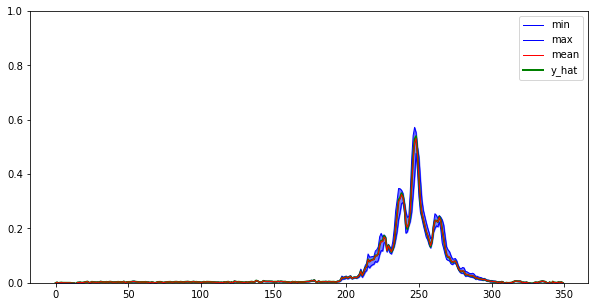

In [21]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

# emulated
print('emulated')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims.T.min(axis=1), y_sims.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated.eps', format='eps')
plt.show()


#### Bootstrap + Get Truth (ParFlow)

In [22]:
'''
bootstrap
'''
# PARFLOW
boots_params_PF, boots_logprob_PF, idxs_PF = randBootstrap(posterior_samples_PF, log_probability_PF)

'''
get 'truth'
'''
# PARFLOW
y_hat_plot_PF = y_hat_full_PF.T.detach().numpy()
y_len = len(y_hat_plot_PF)


#### Run Forward Simulations (ParFlow)

In [23]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list,
                          add_noise=True,f_noise=1e-02, lstm_idx=lstm_idx, y_len=y_len)



Caution, multiple emulators available


#### Plot time series (ParFlow)

Parflow


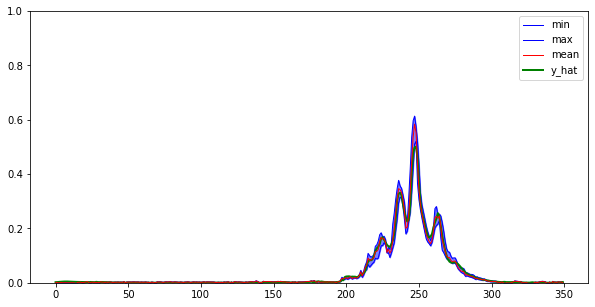

In [24]:
# PARFLOW
print('Parflow')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims_PF.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims_PF.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_PF.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims_PF.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot_PF, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims_PF.T.min(axis=1), y_sims_PF.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.eps', format='eps')
plt.show()

### RMSE

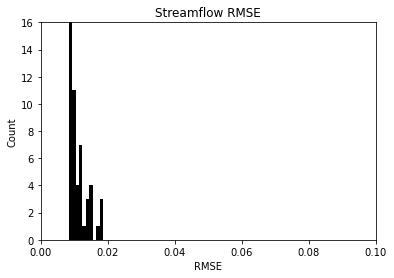

Standard Deviation 0.011290045327125388
Root Mean Squared Error 0.002855473002819449


In [25]:
rmse_arr = np.empty(y_sims_PF.shape[0])
xi = 0
for sim in y_sims_PF:
    rmse_arr[xi] = obj_mets.rmse(y_hat_plot_PF[:,0], sim)
    xi += 1

fig, ax = plt.subplots()
    
# help(plt.hist)
plt.hist(rmse_arr, color='black', density=False, bins=10)
plt.xlim(0,0.1)
plt.ylim(0, 16)
plt.title('Streamflow RMSE')
plt.ylabel('Count')
plt.xlabel('RMSE')
fig.savefig(f'{save_dir}histogram_streamflow_series_{sub}_runidx_{idx}_PF.png')
fig.savefig(f'{save_dir}histogram_streamflow_series_{sub}_runidx_{idx}_PF.eps', format='eps')
plt.show()

print('Standard Deviation', rmse_arr.mean())
print('Root Mean Squared Error', rmse_arr.std())

### Summary Statistics

In [26]:
# get covariance matrix
post_cov_PF = np.cov(posterior_samples_PF.T)
print('covariance matrix is...')
print(post_cov_PF)

# get determinant
det_PF = np.linalg.det(post_cov_PF)
print('\n determinant of covariance matrix is...')
print(det_PF)

# get mahalanobis distance
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html
# https://en.wikipedia.org/wiki/Mahalanobis_distance
# note, using the test data taken from earlier, class 0, a single point
# true theta
true_th_PF = np.array(true_theta)
# extract average for later
mean_th_PF = np.array(posterior_samples_PF.mean(axis=0))
# invert covariance for later
post_cov_inv_PF = np.linalg.inv(post_cov_PF)

print('\n True theta', true_th_PF)
print('\n Mean theta', mean_th_PF)
print('Inverse Covariance', post_cov_inv_PF)

print("\n Man - distance, scipy routine")
dist = distance.mahalanobis(true_th_PF,mean_th_PF,post_cov_inv_PF)
print(dist)

# print('\n Euclidian Distance')
# eu_dist = np.sqrt( (true_th[0] - mean_th[0])**2 + (true_th[1] - mean_th[1])**2)
# eu_dist_norm = np.sqrt( (true_th[0] - mean_th[0])**2/post_cov[0,0] + (true_th[1] - mean_th[1])**2/post_cov[1,1])
# print(eu_dist)
# print(eu_dist_norm)

covariance matrix is...
[[ 1.97367888e-04 -5.98914334e-06]
 [-5.98914334e-06  2.69005233e-04]]

 determinant of covariance matrix is...
5.305712495864594e-08

 True theta [0.599485 0.849485]

 Mean theta [0.51041275 0.81692547]
Inverse Covariance [[5070.10572946  112.881038  ]
 [ 112.881038   3719.91298704]]

 Man - distance, scipy routine
6.695059571260522


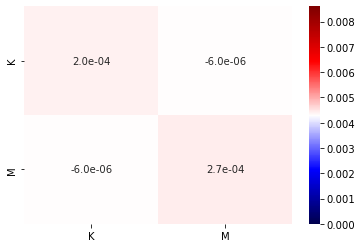

In [27]:
# vmin and max, in an ideal world
vm, vma = -1e-2, 1e-2 #-np.max(np.abs(post_cov)), np.max(np.abs(post_cov)) # (-1e-2, 1e-2)

# normalize for negatives (https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html)
b = 1
a = b - vm

log_post_cov = np.log10(post_cov_PF + a)

# subtract from minimum for log-scale plottage
vm_pl, vma_pl = np.log10(vm+a), np.log10(vma+a)

fig, ax = plt.subplots()

# heat map
sns.heatmap(log_post_cov, vmin=vm_pl, vmax=vma_pl, cmap='seismic',
           xticklabels=['K', 'M'], yticklabels=['K','M'], annot=post_cov_PF, fmt='.1e')
#plt.title(r'Covariance $\Sigma_{M,K}$'+'\n'+r'Determinant $|\Sigma| = $'+f'{det:.1e}'+'\n'+f'Scale min {vm:.1e} max {vma:.1e}''\n'+f'Mahalanobis Distance {dist:.2e}'+ f'\n Euclidian Distance {eu_dist:.2e}')
fig.savefig(f'{save_dir}cov_mat_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.png')
fig.savefig(f'{save_dir}cov_mat_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.eps', format='eps')
plt.show()


## Bulk Stuff

#### Experiment 1_1 Bulk (Emulated Truth using full time series)

In [28]:
# storage
E1_1_arr = np.empty((5, 18))

# loop through all 18
for idx in range(18):
    # ------------- Set Up
    # set true theta
    true_theta = test_params[idx]
    
    # create time series
    y_hat_full = reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx]))
    y_hat = createYHat(y_hat_full, stat_method='full', stat_typ=None, embed_type=None)
    
    # ------------- Parameter Space
    # sample posterior and create log probability
    # - given observation(s), sample posterior, evaluate probability, and plot
    posterior_samples = posterior.sample((n_samples,), x=y_hat) # type - tensor object
    # posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
    log_probability = posterior.log_prob(posterior_samples, x=y_hat).unsqueeze(1) # type - tensor object
    
    # calculate determinent, average euclidean distance, and average log prob
    mean_param = posterior_samples.mean(axis=0)
    median_param = np.quantile(posterior_samples, q=0.5, axis=0)
    # euclidean distance
    euc_dist = norm(true_theta-mean_param)
    
    # probability stuff
    log_prob_true_thetas_ind, log_prob_true_thetas_all, log_prob_true_thetas_flag = genProbThetas(true_theta,
                                        posterior_samples, log_probability, theta_prec=4, mult_factor=10)
    log_prob_out = log_prob_true_thetas_ind.mean()
    
    # covariance of the distribution
    cov_sample = cov(posterior_samples.T)
    # determinant of the distribution
    det_sample = det(cov_sample)
    
    cov_inv_temp = np.linalg.inv(cov_sample)
    dist_temp = distance.mahalanobis(true_theta,mean_param,cov_inv_temp)
    
    # ------------- Streamflow Space
    boots_params, boots_logprob, idxs = randBootstrap(posterior_samples, log_probability)
    y_sims = genSimulation(DataX_test, boots_params, lstm_out_list,
                           add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)

    y_hat_full = convertNumpy(y_hat_full[0,:], toTorch=False)
    
    # calculate NSEs
    RMSE_arr = np.empty(y_sims.shape[0])
    for k in range(y_sims.shape[0]):
        y_o = y_sims[k,:]
        y_o = convertNumpy(y_o, toTorch=False)
        RMSE_arr[k] = obj_mets.rmse(y_o, y_hat_full)
#         NSE_arr[k] = compute_stats(y_o, y_hat_full)[1]
        del y_o

#     NSE_ave = NSE_arr.mean()
#     NSE_std = NSE_arr.std()
    RMSE_ave = RMSE_arr.mean()
    RMSE_std = RMSE_arr.std()

    
    # ------------- Put together
    E1_1_arr[:,idx] = [dist_temp, det_sample, log_prob_out, RMSE_ave, RMSE_std]

    del true_theta, y_hat_full, y_hat, posterior_samples, log_probability, mean_param, median_param
    del euc_dist, log_prob_true_thetas_ind, log_prob_true_thetas_all, log_prob_true_thetas_flag
    del log_prob_out, cov_sample, det_sample, boots_params, boots_logprob, idxs, y_sims
    del RMSE_arr, RMSE_ave, RMSE_std, cov_inv_temp, dist_temp
    

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


#### Experiment 2_1 Bulk (ParFlow Truth using full time series)

In [29]:
# create time series
unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method='full', stat_typ=None, embed_type=None)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)

# storage
E2_1_arr = np.empty((5, 18))

# loop through all 18
for idx in range(18):
    # ------------- Set Up
    # set true theta
    true_theta = test_params[idx]
    
    # set series
    y_hat_PF = unique_series_PF[idx]
    y_hat_full_PF = unique_series_full_PF[idx]
    
    # ------------- Parameter Space
    # sample posterior and create log probability
    # - given observation(s), sample posterior, evaluate probability, and plot
    posterior_samples_PF = posterior.sample((n_samples,), x=y_hat_PF) # type - tensor object
    # posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
    log_probability_PF = posterior.log_prob(posterior_samples_PF, x=y_hat_PF).unsqueeze(1) # type - tensor object

    
    # calculate determinent, average euclidean distance, and average log prob
    mean_param = posterior_samples_PF.mean(axis=0)
    median_param = np.quantile(posterior_samples_PF, q=0.5, axis=0)
    # euclidean distance
    euc_dist = norm(true_theta-mean_param)
    
    # probability stuff
    log_prob_true_thetas_ind, log_prob_true_thetas_all, log_prob_true_thetas_flag = genProbThetas(true_theta,
                                        posterior_samples_PF, log_probability_PF, theta_prec=4, mult_factor=10)
    log_prob_out = log_prob_true_thetas_ind.mean()
    
    # covariance of the distribution
    cov_sample = cov(posterior_samples_PF.T)
    # determinant of the distribution
    det_sample = det(cov_sample)
    
    cov_inv_temp = np.linalg.inv(cov_sample)
    dist_temp = distance.mahalanobis(true_theta,mean_param,cov_inv_temp)
    
    # ------------- Streamflow Space
    boots_params, boots_logprob, idxs = randBootstrap(posterior_samples_PF, log_probability_PF)
    # will need to edit this portion
    y_sims = genSimulation(DataX_test, boots_params, lstm_out_list,
                           add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)

    y_hat_full_PF = convertNumpy(y_hat_full_PF[0,:], toTorch=False)
    
    # calculate NSEs
    RMSE_arr = np.empty(y_sims.shape[0])
    for k in range(y_sims.shape[0]):
        y_o = y_sims[k,:]
        y_o = convertNumpy(y_o, toTorch=False)
        RMSE_arr[k] = obj_mets.rmse(y_o, y_hat_full_PF)
#         NSE_arr[k] = compute_stats(y_o, y_hat_full)[1]
        del y_o

#     NSE_ave = NSE_arr.mean()
#     NSE_std = NSE_arr.std()
    RMSE_ave = RMSE_arr.mean()
    RMSE_std = RMSE_arr.std()

    
    # ------------- Put together
    E2_1_arr[:,idx] = [dist_temp, det_sample, log_prob_out, RMSE_ave, RMSE_std]

    del true_theta, y_hat_full_PF, y_hat_PF, posterior_samples_PF, log_probability_PF, mean_param, median_param
    del euc_dist, log_prob_true_thetas_ind, log_prob_true_thetas_all, log_prob_true_thetas_flag
    del log_prob_out, cov_sample, det_sample, boots_params, boots_logprob, idxs, y_sims
    del RMSE_arr, RMSE_ave, RMSE_std, cov_inv_temp, dist_temp
    

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/posteriorsamputils.py:97: RuntimeWarning: Mean of empty slice.
  log_prob_true_thetas_ind[i] = np.take(log_probability, theta_idx)[0].mean()
/home/SHARED/software/anaconda3/2020.07e/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


### *Dimension 3b* - Ensemble of weakly-trained surrogates -  Increase the diversity of our system representations to combat bias.
### Loading SBI Posteriors

In [32]:
# Directories
sbi_run  = '0819_01_mod2_02_09_lstm_C_0210_01_full_surrogate'
print(sbi_run)
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/{sbi_run}/'

try:
    os.mkdir(f'{save_dir}')
except:
    print('warning: file exists')
    pass

print(save_dir)

lstm_name = '02_09_lstm_C'
lstm_path = f'/home/qh8373/SBI_TAYLOR/data/04_lstm_out/{lstm_name}/'

# load lstm info
with open(lstm_path+'list_df_cond.pkl', 'rb') as fp:
    list_df_cond = pickle.load(fp)

0819_01_mod2_02_09_lstm_C_0210_01_full_surrogate
/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/0819_01_mod2_02_09_lstm_C_0210_01_full_surrogate/


### a. Interpretive plots for each synthetic observations, parameters only

#### Selection Criteria and Load Posterior

In [33]:
# Selection Criteria
sub = 0 # Posterior Sub (Lsim=0 to 10)
idx = 1 #PF:LSTM, 0=82, 1=83, .... #Observation
lstm_idx = 0 #LSTM number in ensemble, nb: should be the same idx as that used in inference = 0
n_samples = 5000 
sbi_dir_sub = f'{sbi_dir}{sub}/'

stat_method = 'full'
stat_typ = None
embed_type = None
out_dim = None

add_noise = False
f_noise = 1e-2
rand_lstm = True

# load posterior
with open(sbi_dir_sub+'posterior.pkl', 'rb') as fp:
    posterior = pickle.load(fp)

#### General loading for posterior sampling

In [34]:
'''
ParFlow truth loads
lstm_df_cond should be loaded
to test ParFlow truths on models trained with LSTMs and previous tested with LSTM synthetic truths
'''
DataX_test, DataY_test, series_len, lstm_out_list = parseListDf(list_df_cond)
test_params, num_params, num_unique, DataX_test = parseUniqueParams(DataX_test, series_len)


'''
sample observation (y_hat) and 'correct' parameter (true_theta)
    y_hat_full is the full timeseries (important for embed and summary stat method)
'''
true_theta = test_params[idx]

#### Sample Posterior (Emulated)

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


<ipython-input-35-fc0f29b1d899>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),



the theta value is tensor([0.5995, 0.8495]) 

Emulated


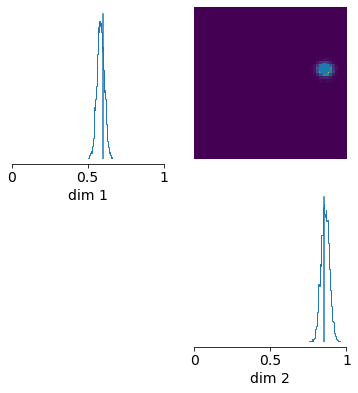

In [35]:
# emulated streamflow
y_hat_full = reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx]))
y_hat = createYHat(y_hat_full, stat_method=stat_method, stat_typ=stat_typ, embed_type=embed_type)

'''
sample posterior and create log probability
'''
# emulated
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples = posterior.sample((n_samples,), x=y_hat) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability = posterior.log_prob(posterior_samples, x=y_hat).unsqueeze(1) # type - tensor object

'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('Emulated')
fig, ax = analysis.pairplot(posterior_samples, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated.eps', format='eps')

plt.show()

#### Sample Posterior (ParFlow)
* nb: to check for bias

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


<ipython-input-36-e3e1d5de5aa7>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),



the theta value is tensor([0.5995, 0.8495]) 

PARFLOW


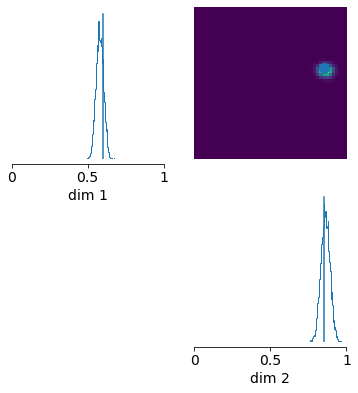

In [36]:
# PF
unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method=stat_method, stat_typ=stat_typ, embed_type=embed_type)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)
y_hat_PF = unique_series_PF[idx]
y_hat_full_PF = unique_series_full_PF[idx]

'''
sample posterior and create log probability
'''
# PF
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples_PF = posterior.sample((n_samples,), x=y_hat_PF) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability_PF = posterior.log_prob(posterior_samples_PF, x=y_hat_PF).unsqueeze(1) # type - tensor object


'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('PARFLOW')
fig, ax = analysis.pairplot(posterior_samples_PF, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.eps', format='eps')

plt.show()



In [37]:
print(log_probability.min())
print(log_probability.max())
print(log_probability.mean(), '\n')

print(log_probability_PF.min())
print(log_probability_PF.max())
print(log_probability_PF.mean(), '\n')

tensor(-3.8018)
tensor(5.4429)
tensor(4.4680) 

tensor(-3.3105)
tensor(5.4194)
tensor(4.3838) 



In [38]:
# ParFlow
# to run forward in ParFlow
out_params_3, out_logprob_3, out_idxs_3 = randBootstrap(posterior_samples_PF, log_probability_PF, n=10)

print(out_params_3)

tensor([[0.5733, 0.8285],
        [0.5969, 0.8829],
        [0.6384, 0.8431],
        [0.6421, 0.7995],
        [0.5801, 0.8713],
        [0.5708, 0.9244],
        [0.5898, 0.8407],
        [0.5765, 0.8052],
        [0.5766, 0.7853],
        [0.5915, 0.8728]])


### b. Interpretive plots for each synthetic observations, streamflow timeseries only

#### Bootstrap + Get Truth (Emulated)

In [39]:
'''
bootstrap
'''
# emulated
boots_params, boots_logprob, idxs = randBootstrap(posterior_samples, log_probability)

'''
get 'truth'
'''
# emulated
y_hat_plot = y_hat_full.T.detach().numpy()
y_len = len(y_hat_plot)

#### Run Forward Simulations (emulators)

In [54]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

y_sims = genSimulation(DataX_test, boots_params, lstm_out_list,
                       add_noise=add_noise, f_noise=f_noise,
                       rand_lstm=rand_lstm,
                       lstm_idx=lstm_idx, y_len=y_len)
print(rand_lstm)
print(len(lstm_out_list))
print(y_sims.max())

Caution, multiple emulators available
True
10
0.5624072551727295


#### Plot time series (emulators)

emulated


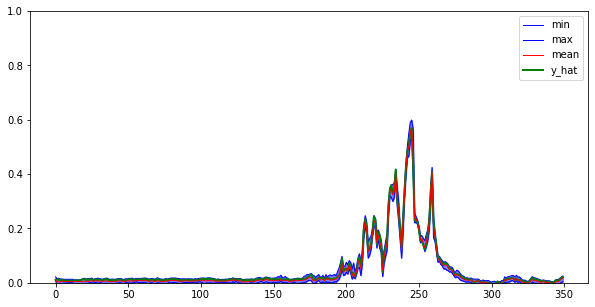

In [60]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

# emulated
print('emulated')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims.T.min(axis=1), y_sims.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated.eps', format='eps')
plt.show()


#### Bootstrap + Get Truth (ParFlow)

In [55]:
'''
bootstrap
'''
# PARFLOW
boots_params_PF, boots_logprob_PF, idxs_PF = randBootstrap(posterior_samples_PF, log_probability_PF)

'''
get 'truth'
'''
# PARFLOW
y_hat_plot_PF = y_hat_full_PF.T.detach().numpy()
y_len = len(y_hat_plot_PF)


#### Run Forward Simulations (ParFlow)

In [63]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list,
                          add_noise=add_noise, f_noise=f_noise,
                           rand_lstm=rand_lstm,
                           lstm_idx=lstm_idx, y_len=y_len)
print(lstm_out_list[1])
print(len(lstm_out_list))
print(y_sims_PF[0,200])

Caution, multiple emulators available
LSTM(
  (lstm): LSTM(10, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
10
0.017962045967578888


#### Plot time series (ParFlow)

Parflow


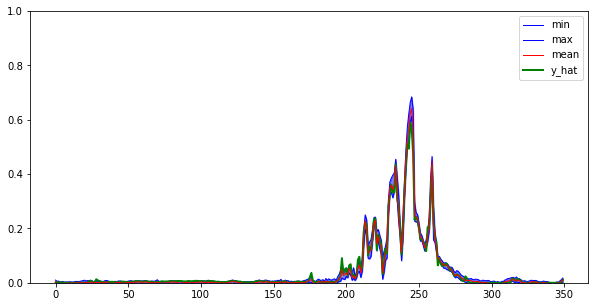

In [63]:
# PARFLOW
print('Parflow')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims_PF.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims_PF.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_PF.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims_PF.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot_PF, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims_PF.T.min(axis=1), y_sims_PF.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.eps', format='eps')
plt.show()

### RMSE

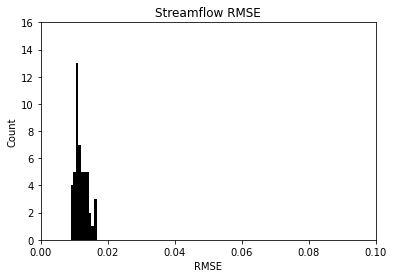

In [42]:
rmse_arr = np.empty(y_sims_PF.shape[0])
xi = 0
for sim in y_sims_PF:
    rmse_arr[xi] = obj_mets.rmse(y_hat_plot_PF[:,0], sim)
    xi += 1

fig, ax = plt.subplots()
    
# help(plt.hist)
plt.hist(rmse_arr, color='black', density=False, bins=10)
plt.xlim(0,0.1)
plt.ylim(0, 16)
plt.title('Streamflow RMSE')
plt.ylabel('Count')
plt.xlabel('RMSE')
fig.savefig(f'{save_dir}histogram_streamflow_series_{sub}_runidx_{idx}_PF_ensemble.png')
fig.savefig(f'{save_dir}histogram_streamflow_series_{sub}_runidx_{idx}_PF_ensemble.eps', format='eps')
plt.show()

In [17]:
print(rmse_arr.mean())
print(rmse_arr.std())

0.01549649429017108
0.004600604391548389


### Summary Statistics

In [84]:
# get covariance matrix
post_cov_PF = np.cov(posterior_samples_PF.T)
print('covariance matrix is...')
print(post_cov_PF)

# get determinant
det_PF = np.linalg.det(post_cov_PF)
print('\n determinant of covariance matrix is...')
print(det_PF)

# get mahalanobis distance
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html
# https://en.wikipedia.org/wiki/Mahalanobis_distance
# note, using the test data taken from earlier, class 0, a single point
# true theta
true_th_PF = np.array(true_theta)
# extract average for later
mean_th_PF = np.array(posterior_samples_PF.mean(axis=0))
# invert covariance for later
post_cov_inv_PF = np.linalg.inv(post_cov_PF)

print('\n True theta', true_th_PF)
print('\n Mean theta', mean_th_PF)
print('Inverse Covariance', post_cov_inv_PF)

print("\n Man - distance, scipy routine")
dist = distance.mahalanobis(true_th_PF,mean_th_PF,post_cov_inv_PF)
print(dist)

# print('\n Euclidian Distance')
# eu_dist = np.sqrt( (true_th[0] - mean_th[0])**2 + (true_th[1] - mean_th[1])**2)
# eu_dist_norm = np.sqrt( (true_th[0] - mean_th[0])**2/post_cov[0,0] + (true_th[1] - mean_th[1])**2/post_cov[1,1])
# print(eu_dist)
# print(eu_dist_norm)

covariance matrix is...
[[ 6.14012220e-04 -1.93894158e-05]
 [-1.93894158e-05  8.29471945e-04]]

 determinant of covariance matrix is...
5.089299608835479e-07

 True theta [0.599485 0.849485]

 Mean theta [0.5776233 0.8588431]
Inverse Covariance [[1629.83516224   38.09839716]
 [  38.09839716 1206.47685706]]

 Man - distance, scipy routine
0.9322119633731679


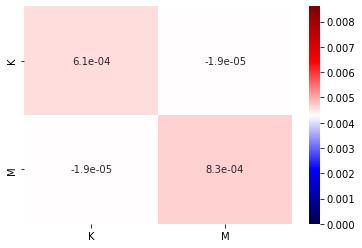

In [85]:
# vmin and max, in an ideal world
vm, vma = -1e-2, 1e-2 #-np.max(np.abs(post_cov)), np.max(np.abs(post_cov)) # (-1e-2, 1e-2)

# normalize for negatives (https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html)
b = 1
a = b - vm

log_post_cov = np.log10(post_cov_PF + a)

# subtract from minimum for log-scale plottage
vm_pl, vma_pl = np.log10(vm+a), np.log10(vma+a)

fig, ax = plt.subplots()

# heat map
sns.heatmap(log_post_cov, vmin=vm_pl, vmax=vma_pl, cmap='seismic',
           xticklabels=['K', 'M'], yticklabels=['K','M'], annot=post_cov_PF, fmt='.1e')
#plt.title(r'Covariance $\Sigma_{M,K}$'+'\n'+r'Determinant $|\Sigma| = $'+f'{det:.1e}'+'\n'+f'Scale min {vm:.1e} max {vma:.1e}''\n'+f'Mahalanobis Distance {dist:.2e}'+ f'\n Euclidian Distance {eu_dist:.2e}')
fig.savefig(f'{save_dir}cov_mat_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF_ensemble.png')
fig.savefig(f'{save_dir}cov_mat_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF_ensemble.eps', format='eps')
plt.show()


## Bulk Stuff

#### Experiment 2_3b Bulk (ParFlow Truth using Ensemble)

In [8]:
# create time series
unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method=stat_method, stat_typ=stat_typ, embed_type=embed_type)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)

# storage
E2_3b_arr = np.empty((5, 18))

# loop through all 18
for idx in range(18):
    # ------------- Set Up
    # set true theta
    true_theta = test_params[idx]
    
    # set series
    y_hat_PF = unique_series_PF[idx]
    y_hat_full_PF = unique_series_full_PF[idx]
    
    # ------------- Parameter Space
    # sample posterior and create log probability
    # - given observation(s), sample posterior, evaluate probability, and plot
    posterior_samples_PF = posterior.sample((n_samples,), x=y_hat_PF) # type - tensor object
    # posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
    log_probability_PF = posterior.log_prob(posterior_samples_PF, x=y_hat_PF).unsqueeze(1) # type - tensor object

    
    # calculate determinent, average euclidean distance, and average log prob
    mean_param = posterior_samples_PF.mean(axis=0)
    median_param = np.quantile(posterior_samples_PF, q=0.5, axis=0)
    # euclidean distance
    euc_dist = norm(true_theta-mean_param)
    
    # probability stuff
    log_prob_true_thetas_ind, log_prob_true_thetas_all, log_prob_true_thetas_flag = genProbThetas(true_theta,
                                        posterior_samples_PF, log_probability_PF, theta_prec=4, mult_factor=10)
    log_prob_out = log_prob_true_thetas_ind.mean()
    
    # covariance of the distribution
    cov_sample = cov(posterior_samples_PF.T)
    # determinant of the distribution
    det_sample = det(cov_sample)
    
    cov_inv_temp = np.linalg.inv(cov_sample)
    dist_temp = distance.mahalanobis(true_theta,mean_param,cov_inv_temp)
    
    # ------------- Streamflow Space
    boots_params, boots_logprob, idxs = randBootstrap(posterior_samples_PF, log_probability_PF)
    # will need to edit this portion
    y_sims = genSimulation(DataX_test, boots_params, lstm_out_list,
                       add_noise=add_noise, f_noise=f_noise,
                       rand_lstm=rand_lstm,
                       lstm_idx=lstm_idx, y_len=y_len)

    y_hat_full_PF = convertNumpy(y_hat_full_PF[0,:], toTorch=False)
    
    # calculate NSEs
    RMSE_arr = np.empty(y_sims.shape[0])
    for k in range(y_sims.shape[0]):
        y_o = y_sims[k,:]
        y_o = convertNumpy(y_o, toTorch=False)
        RMSE_arr[k] = obj_mets.rmse(y_o, y_hat_full_PF)
#         NSE_arr[k] = compute_stats(y_o, y_hat_full)[1]
        del y_o

#     NSE_ave = NSE_arr.mean()
#     NSE_std = NSE_arr.std()
    RMSE_ave = RMSE_arr.mean()
    RMSE_std = RMSE_arr.std()
    
    # ------------- Put together
    E2_3b_arr[:,idx] = [dist_temp, det_sample, log_prob_out, RMSE_ave, RMSE_std]

    del true_theta, y_hat_full_PF, y_hat_PF, posterior_samples_PF, log_probability_PF, mean_param, median_param
    del euc_dist, log_prob_true_thetas_ind, log_prob_true_thetas_all, log_prob_true_thetas_flag
    del log_prob_out, cov_sample, det_sample, boots_params, boots_logprob, idxs, y_sims
    del RMSE_arr, RMSE_ave, RMSE_std, cov_inv_temp, dist_temp
    

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/posteriorsamputils.py:97: RuntimeWarning: Mean of empty slice.
  log_prob_true_thetas_ind[i] = np.take(log_probability, theta_idx)[0].mean()
/home/SHARED/software/anaconda3/2020.07e/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


## End. Integrated Interpretive Plots

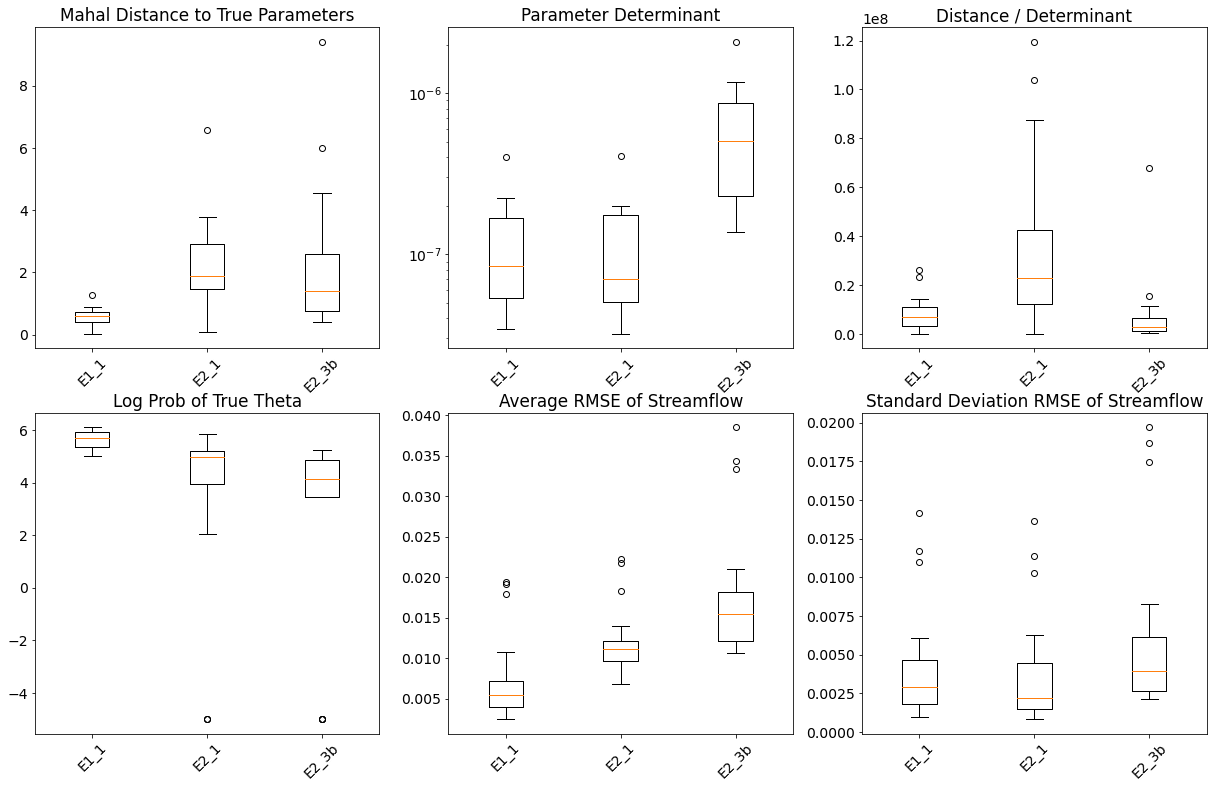

In [30]:
plt.rcParams.update({'font.size': 14})

bar_name = "Experiments in 2"
# idxs = [euc_dist, det_sample, log_prob_out, NSE_ave, NSE_std]
exp_arr = np.empty((5, 18, 3))
exp_list = [E1_1_arr, E2_1_arr, E2_3b_arr]
label_list = ["E1_1", "E2_1", "E2_3b"]

for exp in range(len(exp_list)):
    exp_arr[:,:,exp] = exp_list[exp]

# Create several box plots showing distributions
fig, axs = plt.subplots(2, 3, figsize=(21,13))

axs[0,0].set_title('Mahal Distance to True Parameters')
axs[0,0].boxplot(exp_arr[0,:,:])

axs[0,1].set_title('Parameter Determinant')
axs[0,1].boxplot(exp_arr[1,:,:])
axs[0,1].set_yscale('log')

axs[0,2].set_title('Distance / Determinant')
axs[0,2].boxplot(exp_arr[0,:,:] / exp_arr[1,:,:])
# axs[0,2].set_yscale('log')

axs[1,0].set_title('Log Prob of True Theta')
axs[1,0].boxplot(np.nan_to_num(exp_arr[2,:,:], nan=-5))

axs[1,1].set_title('Average RMSE of Streamflow')
axs[1,1].boxplot(exp_arr[3,:,:])

axs[1,2].set_title('Standard Deviation RMSE of Streamflow')
axs[1,2].boxplot(exp_arr[4,:,:])



for j in range(2):
    for k in range(3):

        axs[j, k].set_xticklabels(label_list, rotation=45)


# fig.savefig(f'{save_dir}bar_relation_{bar_name}.png')
# fig.savefig(f'{save_dir}bar_relation_{bar_name}.eps', format='eps')


plt.show()
plt.close()

## End. Integrated Interpretive Plots

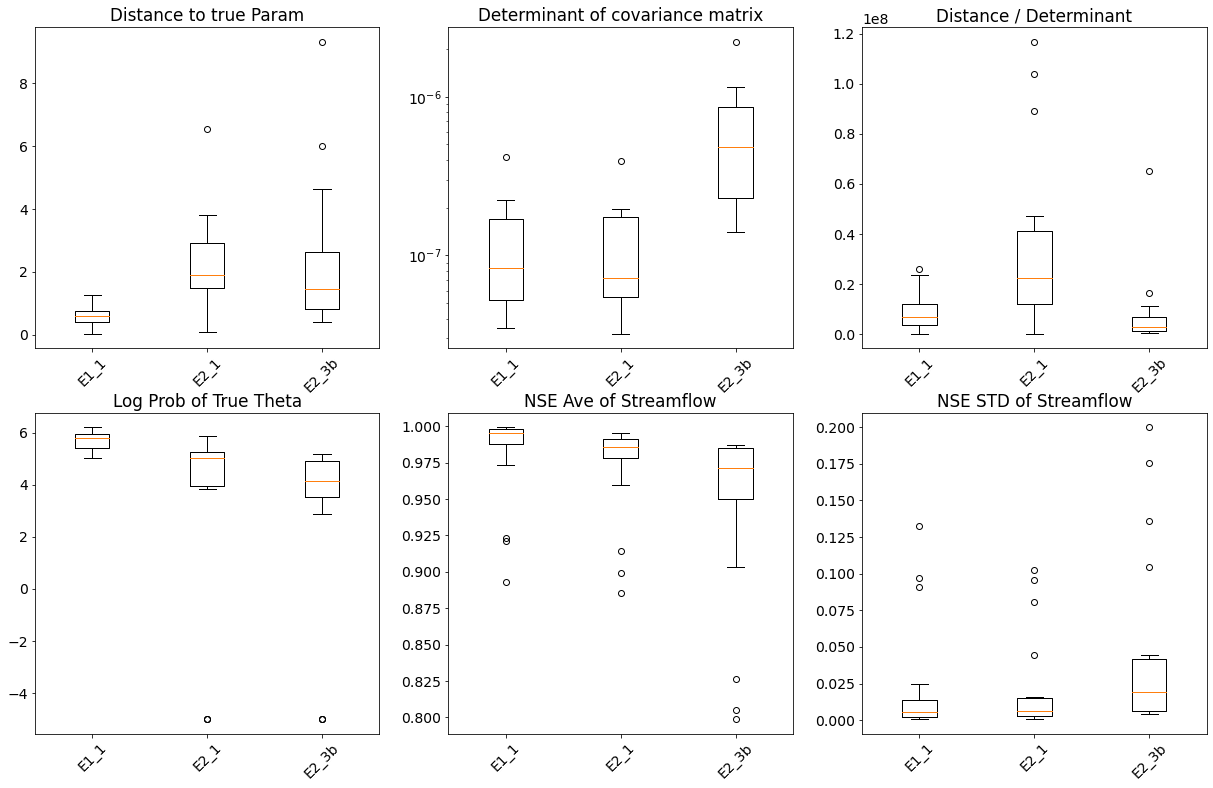

In [172]:
plt.rcParams.update({'font.size': 14})

bar_name = "Experiments in 2"
# idxs = [euc_dist, det_sample, log_prob_out, NSE_ave, NSE_std]
exp_arr = np.empty((5, 18, 3))
exp_list = [E1_1_arr, E2_1_arr, E2_3b_arr]
label_list = ["E1_1", "E2_1", "E2_3b"]

for exp in range(len(exp_list)):
    exp_arr[:,:,exp] = exp_list[exp]

# Create several box plots showing distributions
fig, axs = plt.subplots(2, 3, figsize=(21,13))

axs[0,0].set_title('Distance to true Param')
axs[0,0].boxplot(exp_arr[0,:,:])

axs[0,1].set_title('Determinant of covariance matrix')
axs[0,1].boxplot(exp_arr[1,:,:])
axs[0,1].set_yscale('log')

axs[0,2].set_title('Distance / Determinant')
axs[0,2].boxplot(exp_arr[0,:,:] / exp_arr[1,:,:])
# axs[0,2].set_yscale('log')

axs[1,0].set_title('Log Prob of True Theta')
axs[1,0].boxplot(np.nan_to_num(exp_arr[2,:,:], nan=-5))

axs[1,1].set_title('NSE Ave of Streamflow')
axs[1,1].boxplot(exp_arr[3,:,:])

axs[1,2].set_title('NSE STD of Streamflow')
axs[1,2].boxplot(exp_arr[4,:,:])



for j in range(2):
    for k in range(3):

        axs[j, k].set_xticklabels(label_list, rotation=45)


# if save_bool:
#     fig.savefig(f'{save_dir}bar_relation_{bar_name}.png')
#     fig.savefig(f'{save_dir}bar_relation_{bar_name}.eps', format='eps')


plt.show()
plt.close()